<a href="https://colab.research.google.com/github/marcochow1026/Data-Analytics-Projects/blob/main/Ecommerce_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
import time

import warnings
warnings.filterwarnings('ignore')

In [16]:
#load the data
df = pd.read_csv('/content/ecommerce_customer_churn_dataset.csv')

df.describe()

,Age,Membership_Years,Login_Frequency,Session_Duration_Avg,Pages_Per_Session,Cart_Abandonment_Rate,Wishlist_Items,Total_Purchases,Average_Order_Value,Days_Since_Last_Purchase,...,Returns_Rate,Email_Open_Rate,Customer_Service_Calls,Product_Reviews_Written,Social_Media_Engagement_Score,Mobile_App_Usage,Payment_Method_Diversity,Lifetime_Value,Credit_Balance,Churned
count,47505.000000,50000.000000,50000.000000,46601.000000,47000.000000,50000.000000,46000.000000,50000.000000,50000.000000,47000.000000,...,45509.000000,47472.000000,49832.000000,46500.000000,44000.000000,45000.000000,47500.000000,50000.000000,44500.000000,50000.000000
mean,37.802968,2.984009,11.624660,27.660754,8.737811,57.079973,4.298391,13.111576,123.117330,29.792872,...,6.680913,20.937980,5.681831,2.853312,29.364466,19.371607,2.353874,1440.626292,1966.233258,0.289000
std,11.834668,2.059105,7.810657,10.871013,3.778220,16.282723,3.189754,7.017312,175.569714,29.695062,...,6.143027,14.252561,2.676052,2.328948,20.574021,9.419252,1.110012,907.249443,1225.072166,0.453302
min,5.000000,0.100000,0.000000,1.000000,1.000000,0.000000,0.000000,-13.000000,26.380000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,29.000000,1.400000,6.000000,19.700000,6.000000,46.400000,2.000000,8.000000,87.050000,9.000000,...,2.900000,9.900000,4.000000,1.000000,13.200000,12.500000,2.000000,789.817500,1049.000000,0.000000
50%,38.000000,2.500000,11.000000,26.800000,8.400000,58.100000,4.000000,12.000000,112.970000,21.000000,...,5.400000,19.700000,5.000000,2.000000,27.600000,18.600000,2.000000,1243.415000,1896.000000,0.000000
75%,46.000000,4.000000,17.000000,34.700000,11.200000,68.700000,6.000000,17.000000,144.440000,41.000000,...,9.100000,30.400000,7.000000,4.000000,43.100000,25.500000,3.000000,1874.000000,2791.000000,1.000000
max,200.000000,10.000000,46.000000,75.600000,24.100000,143.743350,28.000000,128.700000,9666.379178,287.000000,...,99.615734,91.700000,21.000000,21.000000,100.000000,61.900000,5.000000,8987.240000,7197.000000,1.000000


Data cleaning need to be done because
1. Maximum value of "Age" is 200
2. Negative and non-integer value appears in "Total_Purchases"
3. Rate that greater than 100 appears in "Cart_Abandonment_Rate" and "Discount_Usage_Rate"

In [17]:
# ====================
# 1. Mark invalid values as NaN
# ====================

# Age > 120 → NaN
df['Age'] = np.where(df['Age'] > 120, np.nan, df['Age'])

# Total_Purchases < 0 → NaN
df['Total_Purchases'] = np.where(df['Total_Purchases'] < 0, np.nan, df['Total_Purchases'])

# Rates that should be between 0 and 100
df['Cart_Abandonment_Rate'] = np.where(df['Cart_Abandonment_Rate'] > 100, np.nan, df['Cart_Abandonment_Rate'])
df['Discount_Usage_Rate'] = np.where(df['Discount_Usage_Rate'] > 100, np.nan, df['Discount_Usage_Rate'])

# ====================
# 2. Impute with median (for ALL numerical columns)
# ====================

numerical_cols = [
    'Age', 'Membership_Years', 'Login_Frequency', 'Session_Duration_Avg',
    'Pages_Per_Session', 'Cart_Abandonment_Rate', 'Wishlist_Items', 'Total_Purchases',
    'Average_Order_Value', 'Days_Since_Last_Purchase', 'Discount_Usage_Rate',
    'Returns_Rate', 'Email_Open_Rate', 'Customer_Service_Calls',
    'Product_Reviews_Written', 'Social_Media_Engagement_Score',
    'Mobile_App_Usage', 'Payment_Method_Diversity', 'Lifetime_Value',
    'Credit_Balance'
]

categorical_cols = ['Gender', 'Country', 'Signup_Quarter']  # Dropped 'City'

# Fill NaN with column median
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

print("All NaN values filled with respective column medians")

# ====================
# 3. Convert to integer where it makes sense
# ====================

int_cols = [
    'Age', 'Login_Frequency', 'Wishlist_Items', 'Total_Purchases',
    'Customer_Service_Calls', 'Product_Reviews_Written',
    'Payment_Method_Diversity', 'Churned'
]

for col in int_cols:
    # Round to nearest integer then convert to int
    df[col] = df[col].round().astype(int)

# Churned should be 0 or 1 (int)
df['Churned'] = df['Churned'].astype(int)

print("Integer columns rounded to the nearest integer and converted to int")

All NaN values filled with respective column medians
Integer columns rounded to the nearest integer and converted to int


In [6]:
df.describe()

,Age,Membership_Years,Login_Frequency,Session_Duration_Avg,Pages_Per_Session,Cart_Abandonment_Rate,Wishlist_Items,Total_Purchases,Average_Order_Value,Days_Since_Last_Purchase,...,Returns_Rate,Email_Open_Rate,Customer_Service_Calls,Product_Reviews_Written,Social_Media_Engagement_Score,Mobile_App_Usage,Payment_Method_Diversity,Lifetime_Value,Credit_Balance,Churned
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000
mean,37.706700,2.984009,11.624660,27.602240,8.717542,0.288840,4.274520,13.125660,123.117330,29.265300,...,6.565861,20.875388,5.679540,2.793580,29.152730,19.294446,2.33618,1440.626292,1958.507600,0.289000
std,11.182113,2.059105,7.810657,10.497234,3.663996,0.453228,3.060573,7.008159,175.569714,28.866043,...,5.872081,13.890225,2.671844,2.256482,19.308632,8.938875,1.08465,907.249443,1155.938248,0.453302
min,5.000000,0.100000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,26.380000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000
25%,30.000000,1.400000,6.000000,20.200000,6.200000,0.000000,2.000000,8.000000,87.050000,9.000000,...,3.100000,10.500000,4.000000,1.000000,15.300000,13.200000,2.00000,789.817500,1164.000000,0.000000
50%,37.000000,2.500000,11.000000,26.800000,8.400000,0.000000,4.000000,12.000000,112.970000,21.000000,...,5.400000,19.700000,5.000000,2.000000,27.600000,18.600000,2.00000,1243.415000,1896.000000,0.000000
75%,45.000000,4.000000,17.000000,34.000000,11.000000,1.000000,6.000000,17.000000,144.440000,39.000000,...,8.600000,29.700000,7.000000,4.000000,40.700000,24.600000,3.00000,1874.000000,2664.000000,1.000000
max,75.000000,10.000000,46.000000,75.600000,24.100000,1.000000,28.000000,129.000000,9666.379178,287.000000,...,99.615734,91.700000,21.000000,21.000000,100.000000,61.900000,5.00000,8987.240000,7197.000000,1.000000


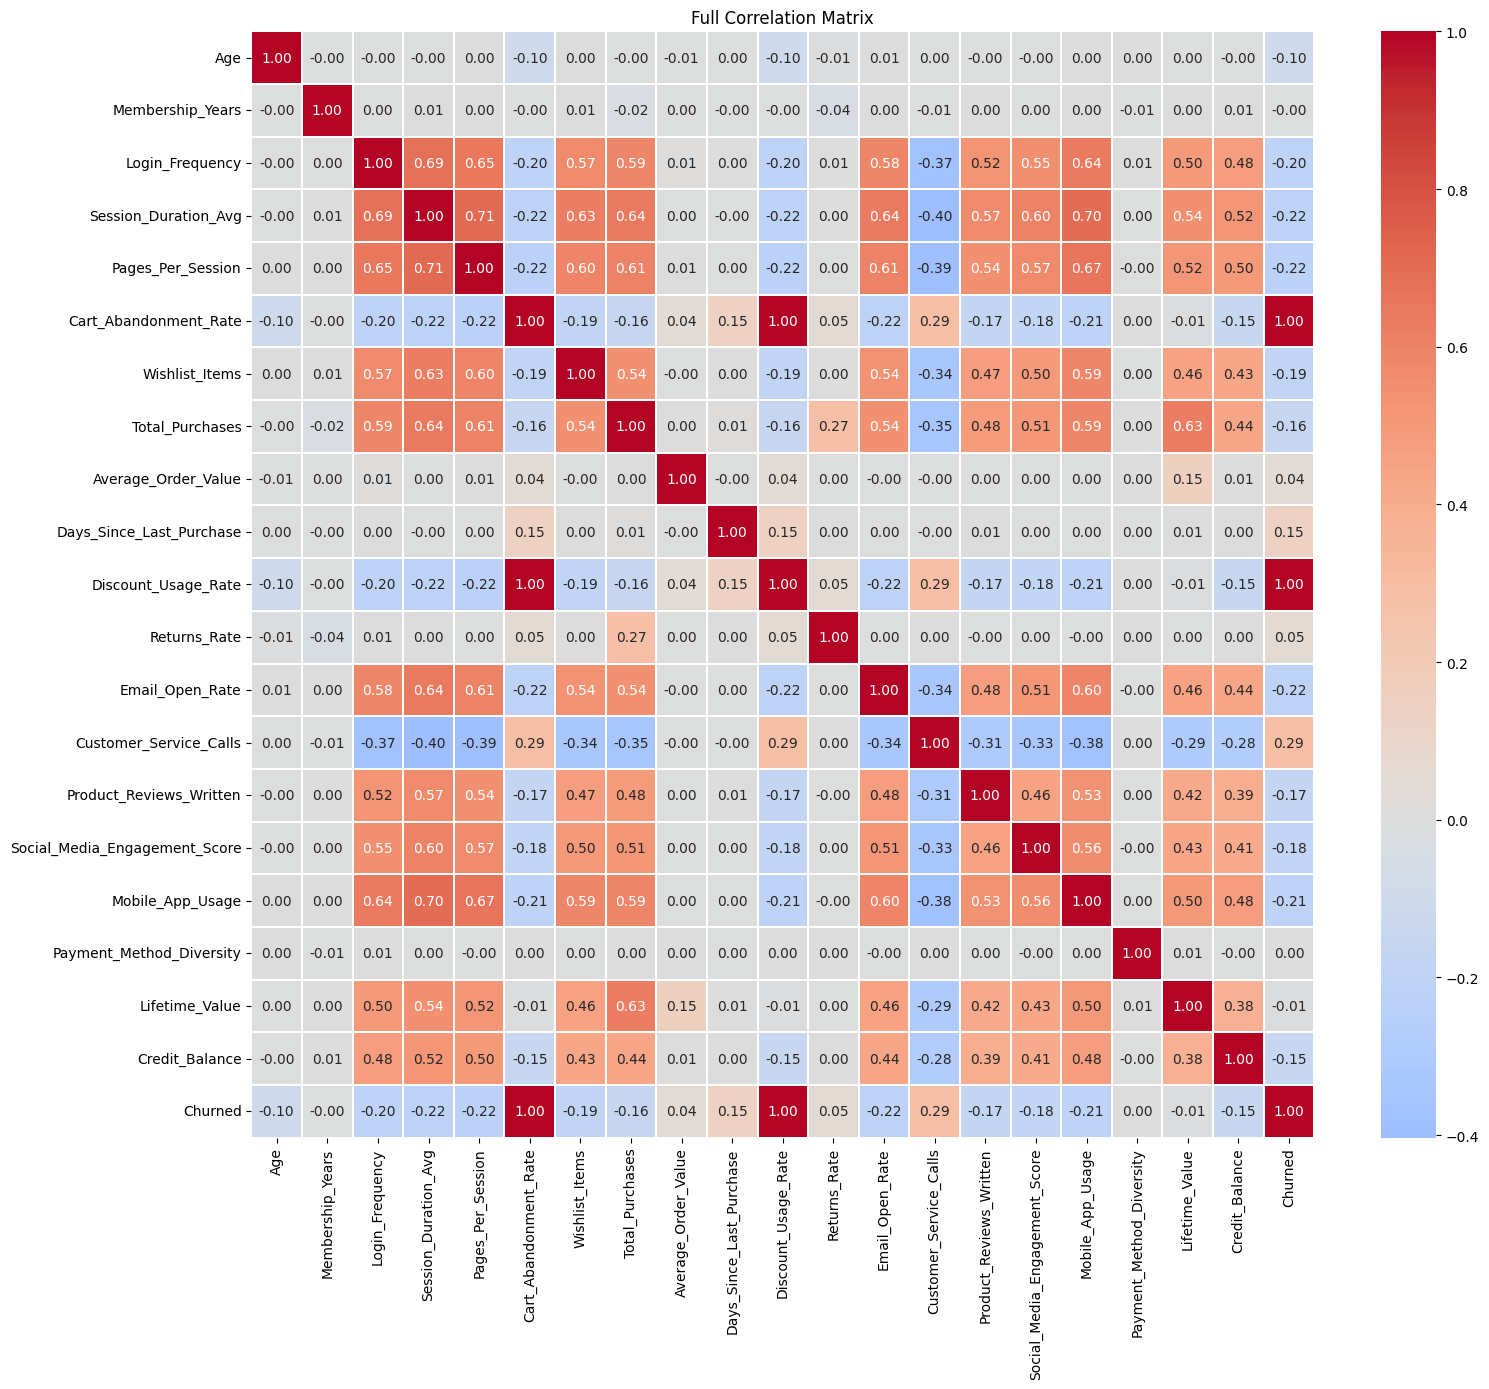

In [7]:
numerical_all = df.select_dtypes(include=['float64', 'int64']).columns
corr_full = df[numerical_all].corr()

plt.figure(figsize=(16, 14))
sns.heatmap(corr_full, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.3)
plt.title('Full Correlation Matrix')
plt.tight_layout()
plt.show()

# **Customer segmentation (K-Mean Clustering)**

K-Mean Clustering divides the customers into different clusters (K cluster), based on certain citeria.

In order to perform customer segmentation, we includes RFM (Recency, Frequency and Monetary) and the engagement metrics like 'Session_Duration_Avg' and 'Customer_Service_Calls' as the citeria of the K-Mean Clustering.

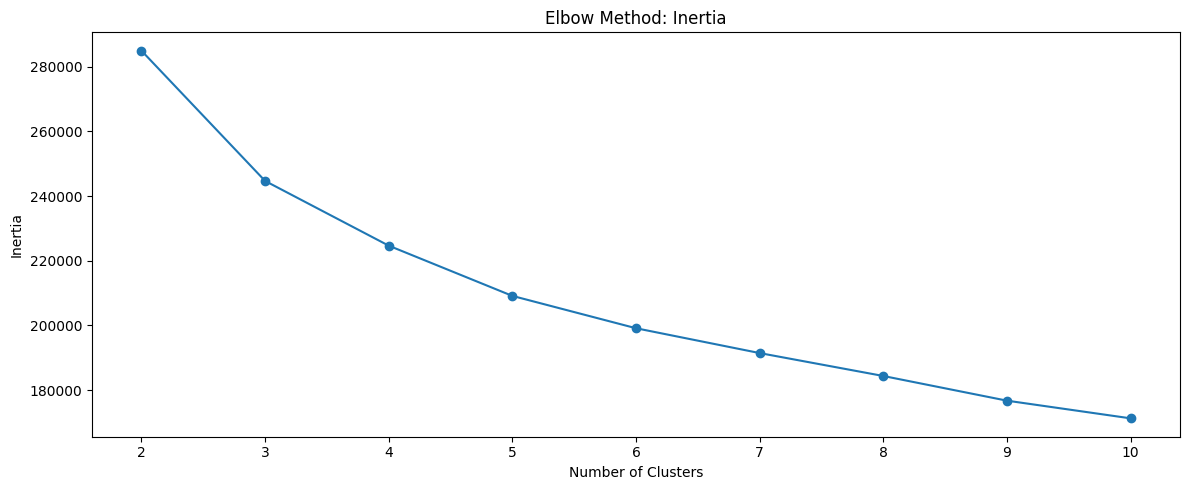

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 1. Select features for clustering (RFM + Engagement)
cluster_features = [
    'Days_Since_Last_Purchase',  # Recency
    'Total_Purchases',  # Frequency
    'Lifetime_Value',  # Monetary
    'Session_Duration_Avg', 'Pages_Per_Session', 'Login_Frequency',  # Engagement
    'Cart_Abandonment_Rate', 'Customer_Service_Calls', 'Mobile_App_Usage',
]

# Filter to non-churned or all (your choice)
df_cluster = df.copy()

# 2. Preprocess
numerical_cols_cluster = [col for col in cluster_features if df[col].dtype in ['int64', 'float64']]
categorical_cols_cluster = [col for col in cluster_features if df[col].dtype == 'object']

preprocessor_cluster = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols_cluster),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_cols_cluster)
    ])

X_cluster = preprocessor_cluster.fit_transform(df_cluster[cluster_features])

# 3. Determine optimal clusters (Elbow Method)
inertia = []
sil_scores = []
k_range = range(2, 11)  # Test 2–10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_cluster, kmeans.labels_))

# Plot Elbow
plt.figure(figsize=(12, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method: Inertia')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.tight_layout()
plt.show()

Using Elbow Method, the optimal number of clusters (k) is 3.

Segment Summary:
         Lifetime_Value  Total_Purchases  Average_Order_Value  \
Cluster                                                         
0                855.94             7.98               118.41   
1               2467.32            21.98               129.89   
2               1544.57            14.13               124.68   

         Session_Duration_Avg  Cart_Abandonment_Rate  Customer_Service_Calls  \
Cluster                                                                        
0                       19.33                  69.41                    7.05   
1                       42.10                  36.55                    3.61   
2                       29.08                  54.25                    5.27   

         Churned  Frequency  
Cluster                      
0           0.41      20470  
1           0.19       9644  
2           0.21      19886  


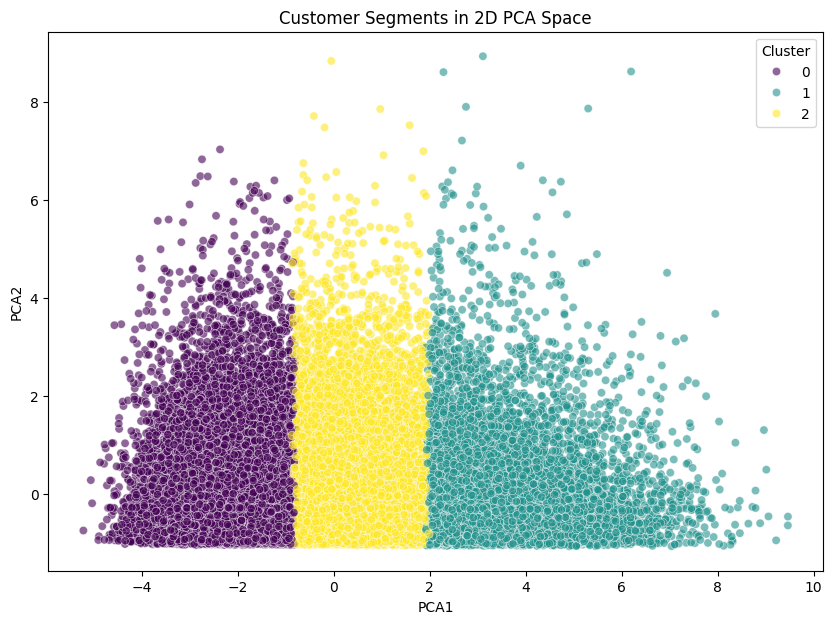

In [ ]:
optimal_k = 3

# 4. Fit KMeans and assign labels
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_cluster['Frequency'] = kmeans.fit_predict(X_cluster)

# 5. Analyze segments (mean values per cluster)
segment_summary = df_cluster.groupby('Cluster').agg({
    'Lifetime_Value': 'mean',
    'Total_Purchases': 'mean',
    'Average_Order_Value': 'mean',
    'Session_Duration_Avg': 'mean',
    'Cart_Abandonment_Rate': 'mean',
    'Customer_Service_Calls': 'mean',
    'Churned': 'mean',  # Churn rate per segment
    'Frequency': 'count'  # Segment size
}).round(2)

print("Segment Summary:")
print(segment_summary)

# 6. Visualize clusters in 2D (PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df_cluster['Cluster'], palette='viridis', alpha=0.6)
plt.title('Customer Segments in 2D PCA Space')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

The three clusters shows different groups of customers.

Cluster 1 could be consider as **loyal customers** (consists of 19% of customers). They contribute the **highest RFM** (lifetime value, total number of purchases and average order value), **highest engagement** and **lowest churn rate** (most loyal).

In contrast, Cluster 0 is the opposite group of customers (consists of 41% of customers). They contribute the **highest RFM** , **highest engagement** and **lowest churn rate**. But at the same time, those customer may be the newcomers.

# **Predicting the Probability of Churn**

# **Multinominal Logistic Regression**

In [49]:
categorical_cols = ['Gender', 'Country', 'Signup_Quarter']

y = df['Churned']
X = df[numerical_cols + categorical_cols].copy()

# One-hot encode categoricals
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Force all to float64
X = X.astype('float64')

# Add constant for intercept
X = sm.add_constant(X)

print(f"Dataset shape after preprocessing: {X.shape[0]} rows, {X.shape[1]-1} features")

def backward_elimination_logit(X, y, significance_level=0.05):
    current_features = list(X.columns)
    num_vars = len(current_features)

    for i in range(num_vars - 1):
        # Fit model on current features
        model = sm.Logit(y, X[current_features]).fit(disp=0)

        # Get p-values excluding constant (index 0)
        p_values = model.pvalues[1:]
        feature_names = current_features[1:]

        max_p_value = max(p_values)
        if max_p_value > significance_level:
            max_p_index = np.argmax(p_values) + 1
            removed_feature = current_features[max_p_index]
            print(f"Step {i+1}: Removed '{removed_feature}' (p={max_p_value:.4f})")

            # Remove from DataFrame
            X = X.drop(columns=[removed_feature])
            current_features = list(X.columns)
        else:
            break

    final_model = sm.Logit(y, X).fit()
    print("\nFinal model summary:")
    print(final_model.summary())
    print(f"\nFinal features ({len(X.columns)-1}):")
    print(X.columns[1:].tolist())

    return X, final_model

X_optimized, final_model = backward_elimination_logit(X, y)

Dataset shape after preprocessing: 50000 rows, 32 features
Step 1: Removed 'Signup_Quarter_Q2' (p=0.9245)
Step 2: Removed 'Membership_Years' (p=0.9235)
Step 3: Removed 'Country_Canada' (p=0.8810)
Step 4: Removed 'Average_Order_Value' (p=0.8643)
Step 5: Removed 'Session_Duration_Avg' (p=0.6244)
Step 6: Removed 'Credit_Balance' (p=0.6235)
Step 7: Removed 'Country_India' (p=0.5348)
Step 8: Removed 'Country_Germany' (p=0.6277)
Step 9: Removed 'Country_USA' (p=0.6046)
Step 10: Removed 'Gender_Male' (p=0.4101)
Step 11: Removed 'Country_Japan' (p=0.3250)
Step 12: Removed 'Payment_Method_Diversity' (p=0.3268)
Step 13: Removed 'Social_Media_Engagement_Score' (p=0.1969)
Step 14: Removed 'Country_UK' (p=0.1531)
Step 15: Removed 'Gender_Other' (p=0.0999)
Step 16: Removed 'Login_Frequency' (p=0.0638)
Step 17: Removed 'Signup_Quarter_Q3' (p=0.0520)
Optimization terminated successfully.
         Current function value: 0.485817
         Iterations 6

Final model summary:
                           Lo

After selection of features using backward elimination based on p-value, the final model consist of 19 features to predict the probability of churn, including numerical variables like **Customer_Service_Calls** and categorical variables like **Signup_Quarter_Q4** (indicates whether the customer signup during the 4th Quarter)


Train size: 40000, Test size: 10000

Test Accuracy: 0.7749

Confusion Matrix:


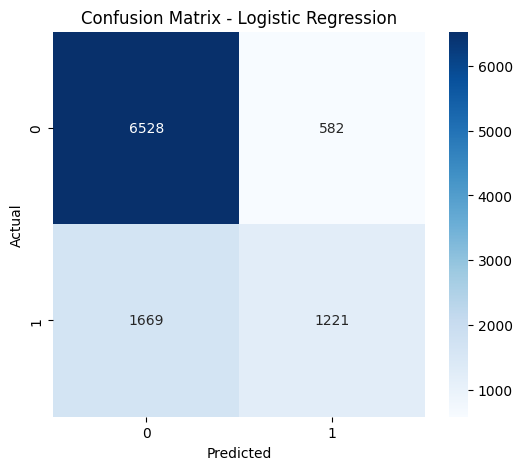

Classification Report:
              precision    recall  f1-score   support

   Non-Churn       0.80      0.92      0.85      7110
       Churn       0.68      0.42      0.52      2890

    accuracy                           0.77     10000
   macro avg       0.74      0.67      0.69     10000
weighted avg       0.76      0.77      0.76     10000


Top 5 Most Influential Features:
                        Coefficient  Odds Ratio Exp(Coef) Interpretation
Customer_Service_Calls       0.2163      1.2415     +0.2415x higher odds
Signup_Quarter_Q4            0.1228      1.1306     +0.1306x higher odds
Country_France              -0.0919      0.9122       0.0878x lower odds
Total_Purchases             -0.0438      0.9572       0.0428x lower odds
Cart_Abandonment_Rate        0.0369      1.0376     +0.0376x higher odds


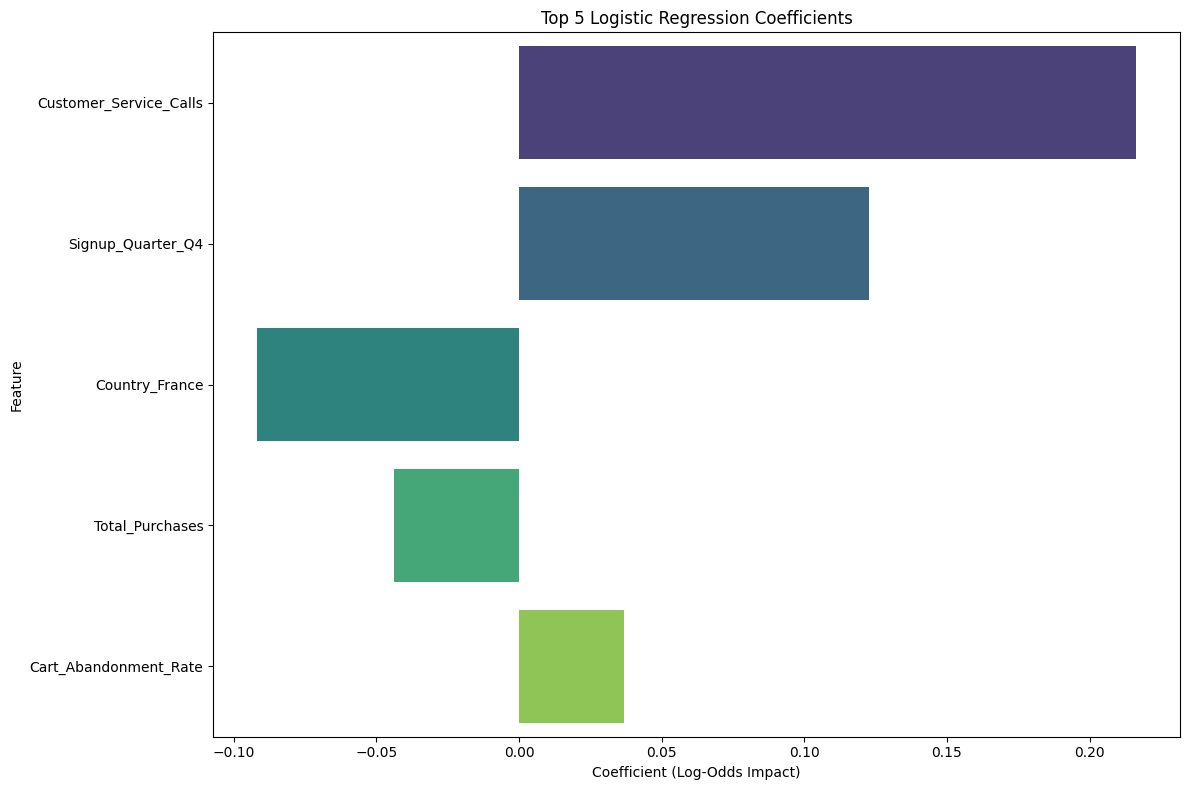

In [50]:
# Use the final selected features from the stepwise process
X_selected = X[selected_features]  # includes 'const'

# Train-test split (stratified to maintain churn proportion)
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

# Fit the final model on the training data
model = sm.Logit(y_train, X_train).fit(disp=0)

# Predict probabilities on test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Evaluation
print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")

# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Churn', 'Churn']))

# Top 5 features by absolute coefficient value (excluding constant)
params = final_model.params.drop('const')
odds_ratios = np.exp(params)

# Get top 5 by absolute magnitude
top5_abs = params.abs().sort_values(ascending=False).head(5)

top5_df = pd.DataFrame({
    'Coefficient': params[top5_abs.index].round(4),
    'Odds Ratio' : odds_ratios[top5_abs.index].round(4),
    'Exp(Coef) Interpretation': np.where(
        odds_ratios[top5_abs.index] > 1,
        '+' + (odds_ratios[top5_abs.index] - 1).round(4).astype(str) + 'x higher odds',
        (1 - odds_ratios[top5_abs.index]).round(4).astype(str) + 'x lower odds'
    )
})

print("\nTop 5 Most Influential Features:")
print(top5_df)

# Plot: Top 5 features by absolute coefficient
plt.figure(figsize=(12, 8))
sns.barplot(
    data=top5_df,
    x='Coefficient',
    y=top5_abs.index,
    legend=False,
    palette='viridis'
)
plt.title(f'Top 5 Logistic Regression Coefficients')
plt.xlabel('Coefficient (Log-Odds Impact)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

The Logistic Regression model give a 77% accuracy.

Key Insights:
1. Customer Service Call is the most influential feature, the odds ratio of churn will **increase for 24.2%** for one extra Customer Service Call.

2. If the customer signed up in the fourth quarter, the odds ratio of churn will be **13.1% higher** than customer signed up in the other quarters.

3. Customers from France have a **8.9% lower** odds ratio of churn, compared to customers from other countries.

4. The odds ratio of churn will **decrease for 4.3%** for one extra purchase.

5. The odds ratio of churn will **increase for 3.8%** for 1% increase in Cart Abandonment Rate.

# **Random Forest**

Features after encoding: 32
Train shape: (40000, 32), Test shape: (10000, 32)

Random Forest Accuracy: 0.9104
Random Forest Classification Report:
              precision    recall  f1-score   support

   Non-Churn       0.93      0.95      0.94      7110
       Churn       0.86      0.82      0.84      2890

    accuracy                           0.91     10000
   macro avg       0.90      0.88      0.89     10000
weighted avg       0.91      0.91      0.91     10000



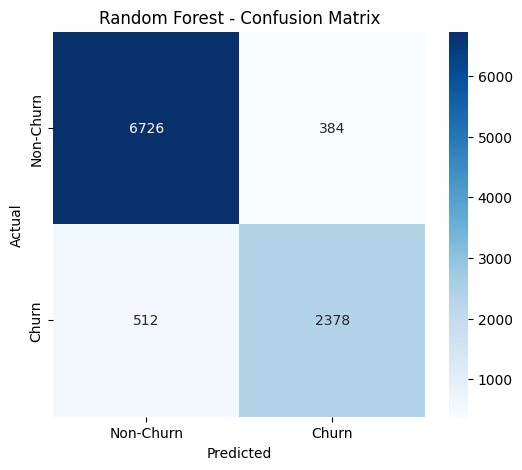

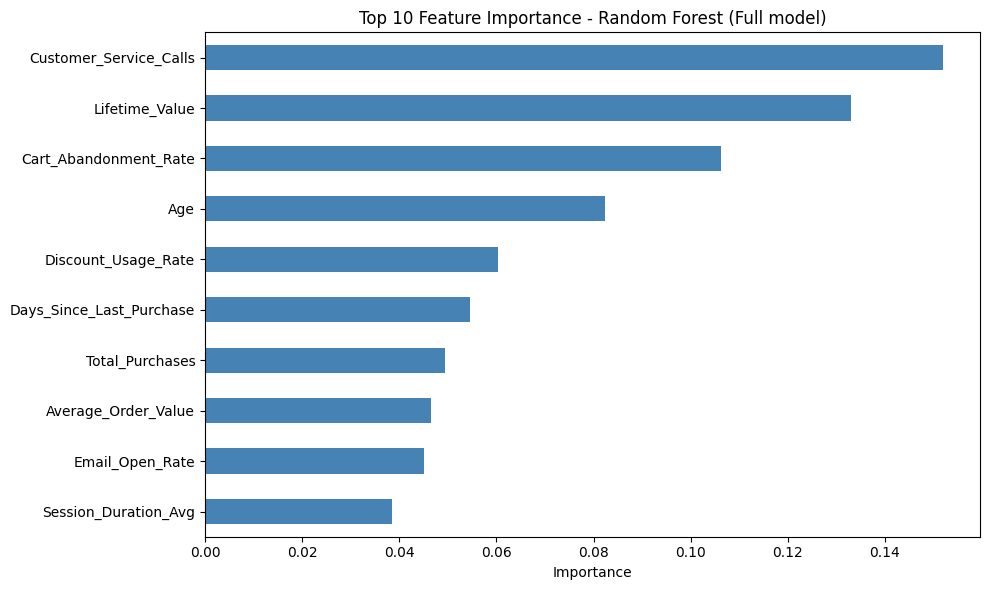

Top 10 Most Important Features:
Customer_Service_Calls      0.1520
Lifetime_Value              0.1329
Cart_Abandonment_Rate       0.1063
Age                         0.0824
Discount_Usage_Rate         0.0603
Days_Since_Last_Purchase    0.0546
Total_Purchases             0.0495
Average_Order_Value         0.0466
Email_Open_Rate             0.0452
Session_Duration_Avg        0.0385
dtype: float64


In [52]:
X_full = df[numerical_cols + categorical_cols].copy()
y = df['Churned']

X_full_rf = pd.get_dummies(X_full, columns=categorical_cols, drop_first=True)
X_full_rf = X_full_rf.astype('float64')

all_feature_names = X_full_rf.columns.tolist()
print(f"Features after encoding: {len(all_feature_names)}")

X_train, X_test, y_train, y_test = train_test_split(
    X_full_rf, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

rf_initial_model = RandomForestClassifier(
    n_estimators=1000,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features=np.sqrt(len(all_feature_names)).astype(int),
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_initial_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_initial_model.predict(X_test)
y_pred_prob_rf = rf_initial_model.predict_proba(X_test)[:, 1]

# Evaluation
print(f"\nRandom Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Non-Churn', 'Churn']))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Churn', 'Churn'],
            yticklabels=['Non-Churn', 'Churn'])
plt.title('Random Forest - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance (Top 10)
importances = pd.Series(rf_initial_model.feature_importances_, index=X_full_rf.columns)
top10 = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top10.sort_values().plot(kind='barh', color='steelblue')
plt.title('Top 10 Feature Importance - Random Forest (Full model)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
print(top10.round(4))

The random forest model including all 32 features give 91.04% accuracy.

The most important feature in this model is Customer Service Call (importance: 15.20%), followed by Lifetime Value (importance: 13.29%), then Cart Abandonment Rate (importance: 10.63%)

Selected features: 16
Removed          : 16

Selected features:
['Age', 'Login_Frequency', 'Session_Duration_Avg', 'Pages_Per_Session', 'Cart_Abandonment_Rate', 'Wishlist_Items', 'Total_Purchases', 'Average_Order_Value', 'Days_Since_Last_Purchase', 'Discount_Usage_Rate', 'Returns_Rate', 'Email_Open_Rate', 'Customer_Service_Calls', 'Social_Media_Engagement_Score', 'Mobile_App_Usage', 'Lifetime_Value']

Training final Random Forest on selected features...

Final Model Performance (with 16 selected features):
Accuracy: 0.9150

Classification Report:
              precision    recall  f1-score   support

   Non-Churn       0.93      0.95      0.94      7110
       Churn       0.87      0.83      0.85      2890

    accuracy                           0.92     10000
   macro avg       0.90      0.89      0.90     10000
weighted avg       0.91      0.92      0.91     10000



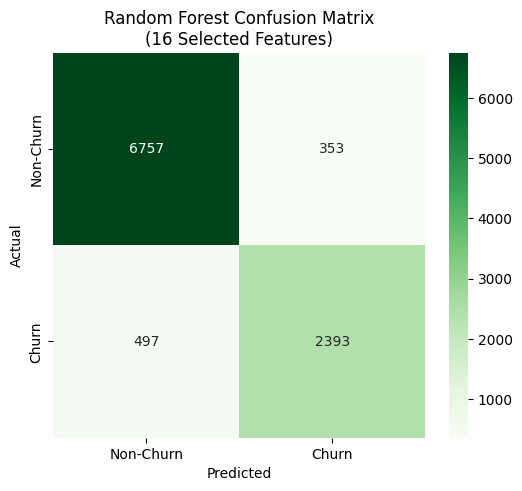

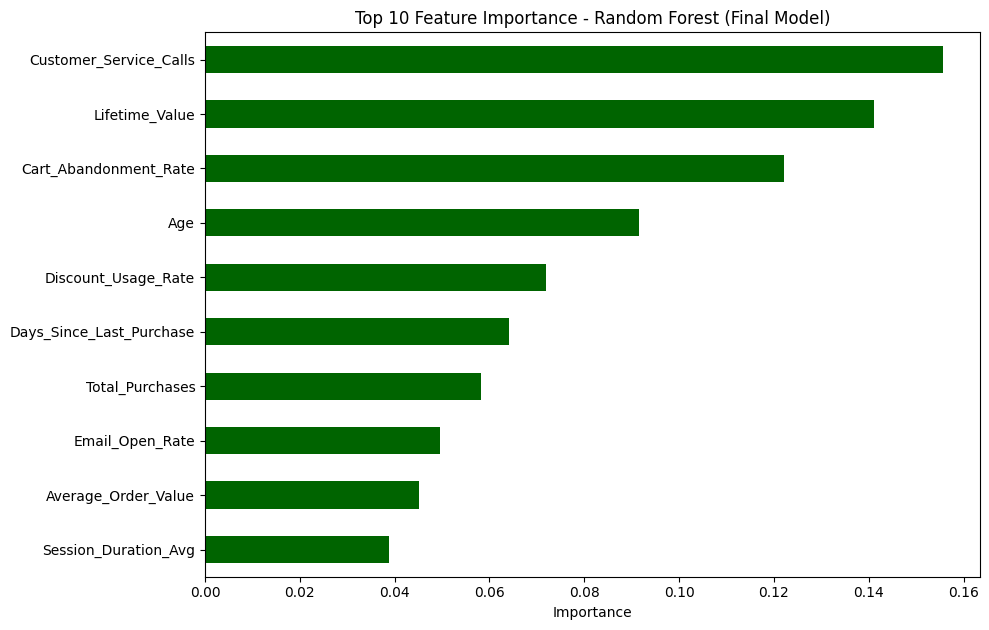


Final Ranked Features (Top 10):
Customer_Service_Calls      0.1557
Lifetime_Value              0.1411
Cart_Abandonment_Rate       0.1222
Age                         0.0915
Discount_Usage_Rate         0.0720
Days_Since_Last_Purchase    0.0641
Total_Purchases             0.0582
Email_Open_Rate             0.0496
Average_Order_Value         0.0451
Session_Duration_Avg        0.0388
dtype: float64


In [57]:
# Feature Selection using SelectFromModel (Keep features above median)
selector = SelectFromModel(rf_initial_model, threshold='median', prefit=True)

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

selected_mask = selector.get_support()
selected_features = [name for name, keep in zip(all_feature_names, selected_mask) if keep]

n_selected = len(selected_features)

print(f"Selected features: {n_selected}")
print(f"Removed          : {X_full_rf.shape[1] - n_selected}")
print(f"\nSelected features:\n{list(selected_features)}")

X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_features)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_features)

# Train final model on selected features
print("\nTraining final Random Forest on selected features...")
rf_final = RandomForestClassifier(
    n_estimators=1000,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    max_features=np.sqrt(n_selected).astype(int),
    n_jobs=-1
)
rf_final.fit(X_train_selected_df, y_train)

# Predictions
y_pred = rf_final.predict(X_test_selected_df)

# Evaluation
print(f"\nFinal Model Performance (with {n_selected} selected features):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Churn', 'Churn']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Non-Churn', 'Churn'],
            yticklabels=['Non-Churn', 'Churn'])
plt.title(f'Random Forest Confusion Matrix\n({n_selected} Selected Features)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Final Importance (Top 10)
final_importances = pd.Series(rf_final.feature_importances_, index=selected_features)
final_importances_top10 = final_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, max(6, n_selected * 0.4)))
final_importances_top10.sort_values(ascending=True).plot(kind='barh', color='darkgreen')
plt.title('Top 10 Feature Importance - Random Forest (Final Model)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("\nFinal Ranked Features (Top 10):")
print(final_importances_top10.round(4))

We improve the random forest model with eliminating the variables that below the median importance, and the final model gives 91.50% accuracy.

The top 3 most important feature in this model is same as the original model: Customer Service Call (importance: 15.57%), followed by Lifetime Value (importance: 14.11%), then Cart Abandonment Rate (importance: 12.22%)

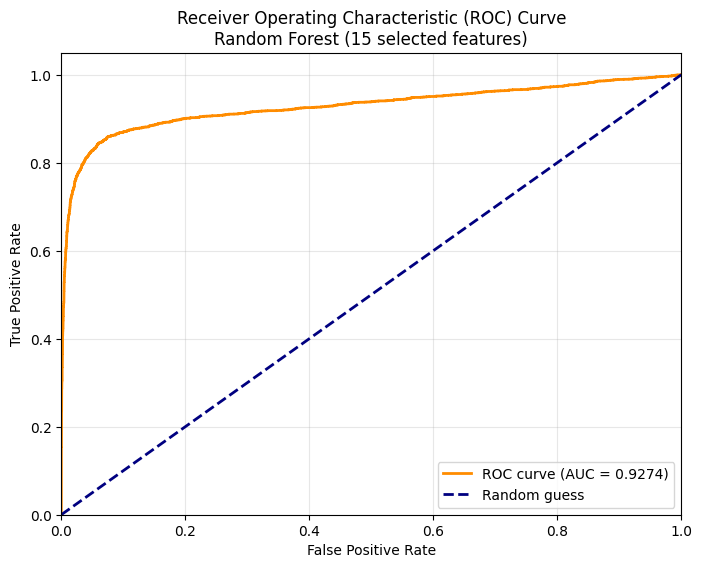

AUC: 0.9274


In [32]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class (Churn = 1)
y_pred_proba = rf_final.predict_proba(X_test_selected_df)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\nRandom Forest (15 selected features)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

# Optional: Print AUC value
print(f"AUC: {roc_auc:.4f}")

Top 5 most important features:
1. Customer_Service_Calls (importance: 0.1557)
2. Lifetime_Value (importance: 0.1411)
3. Cart_Abandonment_Rate (importance: 0.1222)
4. Age (importance: 0.0915)
5. Discount_Usage_Rate (importance: 0.0720)


KeyboardInterrupt: 

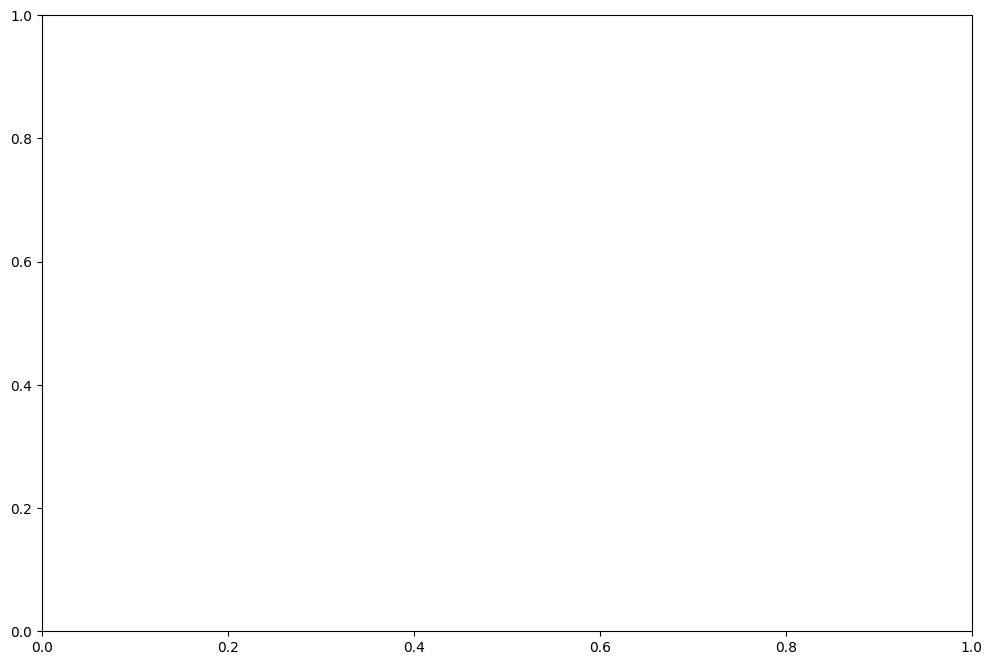

In [33]:
# Partial Dependence Plots for the top 5 most important features
from sklearn.inspection import PartialDependenceDisplay

# Get top 5 features from the final Random Forest (after feature selection)
final_importances = pd.Series(rf_final.feature_importances_, index=selected_features)
top5_features = final_importances.sort_values(ascending=False).head(5).index.tolist()

print("Top 5 most important features:")
for i, feat in enumerate(top5_features, 1):
    imp = final_importances[feat]
    print(f"{i}. {feat} (importance: {imp:.4f})")

fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    rf_final,
    X_train_selected_df,
    features=top5_features,
    target=1,                    # Probability of Churn
    kind="average",
    grid_resolution=60,
    ax=ax
)
plt.suptitle('Partial Dependence Plots - Probability of Churn\nTop 5 Most Important Features (Random Forest)',
             fontsize=14, y=0.9)
plt.tight_layout()
plt.show()

Partial Dependence Plots show the change of probability of churn over different variables.

1. The probability of churn sharply increase after the number of customer service call increase to 5 or more, from around 25% to 45-50%.

2. For Lifetime Value, the probability of churn decreases from 0 to 2000, but a sudden increase appears at around 2000. However, such cases might be outliers, some new customers may purchase high value goods and churned afterwards.

3. The probability of churn slowly increase after the cart abandonment rate increase to 60% or more, from around 25% to 45%.

4. The probability of churn for customers younger than 25 years old (50%) is significantly differ from those older than 25 years old (30%).

5. The probability of churn for discount usage rate lower than 30% customers (probability around 40%) is significantly differ from those higher than 30% (probability around 30%).